In [25]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))
print("CUDA Version:", torch.version.cuda)

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 12.1


In [26]:
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')


In [27]:
# from google.colab import drive
# drive.mount('/content/drive')


In [28]:
DATASET_PATH = "D:\major_project\parasite-dataset"


In [29]:
import os

classes = sorted([
    folder for folder in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, folder))
    and not folder.startswith('.')
])

print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: ['Babesia', 'Leishmania', 'Leukocyte', 'Plasmodium', 'RBCs', 'Toxoplasma', 'Trichomonad', 'Trypanosome']
Number of classes: 8


In [58]:
import os

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    print(f"\nClass: {cls}")
    print(os.listdir(cls_path)[:10])


Class: Babesia
['0109_141708_1.jpg', '0109_141738_1.jpg', '0109_141738_2.jpg', '0109_141738_3.jpg', '0109_141738_4.jpg', '0109_141754_1.jpg', '0109_141754_2.jpg', '0109_141754_3.jpg', '0109_141754_4.jpg', '0109_141754_5.jpg']

Class: Leishmania
['0114_153242_1.jpg', '0114_153242_2.jpg', '0114_153242_3.jpg', '0114_153242_4.jpg', '0114_153334_1.jpg', '0114_153334_2.jpg', '0114_153334_3.jpg', '0114_153334_4.jpg', '0114_153334_5.jpg', '0114_153334_6.jpg']

Class: Leukocyte
['0926_173121_1.jpg', '0926_173121_10.jpg', '0926_173121_11.jpg', '0926_173121_12.jpg', '0926_173121_13.jpg', '0926_173121_14.jpg', '0926_173121_15.jpg', '0926_173121_16.jpg', '0926_173121_17.jpg', '0926_173121_18.jpg']

Class: Plasmodium
['1225_173759_1.jpg', '1225_173759_17.jpg', '1225_173807_10.jpg', '1225_173807_21.jpg', '1225_173807_22.jpg', '1225_173807_28.jpg', '1225_173815_1.jpg', '1225_173815_2.jpg', '1225_173815_25.jpg', '1225_173815_3.jpg']

Class: RBCs
['0mcell_test.jpg', '0mcell_train.jpg', '1000mcell_train

In [53]:
import os
import pandas as pd

image_paths = []
labels = []
splits = []

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    
    for img in os.listdir(cls_path):
        full_path = os.path.join(cls_path, img)
        
        if img.endswith("_train.jpg"):
            split_type = "train"
        elif img.endswith("_test.jpg"):
            split_type = "test"
        else:
            continue
        
        image_paths.append(full_path)
        labels.append(cls)
        splits.append(split_type)

data = pd.DataFrame({
    "filepath": image_paths,
    "label": labels,
    "split": splits
})

train_df = data[data["split"] == "train"]
test_df = data[data["split"] == "test"]

In [54]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42
)

In [56]:
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain distribution:\n", train_df["label"].value_counts(normalize=True))
print("\nValidation distribution:\n", val_df["label"].value_counts(normalize=True))
print("\nTest distribution:\n", test_df["label"].value_counts(normalize=True))

Train size: 5083
Validation size: 898
Test size: 1000

Train distribution:
 label
RBCs    1.0
Name: proportion, dtype: float64

Validation distribution:
 label
RBCs    1.0
Name: proportion, dtype: float64

Test distribution:
 label
RBCs    1.0
Name: proportion, dtype: float64


**Image resizing, normalaizing,augmentation**

If we load everything into **memory:**

-High RAM usage

-Slow

-Not scalable





**Generator:**

-Memory efficient

-Professional approach

-Standard in medical AI

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_loader = test_gen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_loader = test_gen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 24008 validated image filenames belonging to 8 classes.
Found 5145 validated image filenames belonging to 8 classes.
Found 5145 validated image filenames belonging to 8 classes.


***Computing class weights***

In [68]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_indices = train_loader.class_indices
y_train = train_df['label'].map(class_indices).values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 3.6552984165651643, 1: 1.586991010047594, 2: 3.1163032191069573, 3: 5.0864406779661016, 4: 0.4766518424396442, 5: 0.6406917164816396, 6: 0.42303354947843247, 7: 1.7980826842420612}


#Build Efficientnet B0 Model

In [42]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 🔥 IMPORTANT: Unfreeze only last 30 layers
base_model.trainable = True

# for layer in base_model.layers[:-15]:
#     layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_3[0][0]'

**Compilation of Model**

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # watch validation loss
    patience=3,              # wait 3 epochs before stopping
    restore_best_weights=True
)

**Training The Model**

In [46]:
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=20,
    # class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
751/751 [==============================] - 2716s 4s/step - loss: 0.1052 - accuracy: 0.9708 - val_loss: 6.1661 - val_accuracy: 0.0400
Epoch 2/20
751/751 [==============================] - 2650s 4s/step - loss: 0.0606 - accuracy: 0.9842 - val_loss: 5.2693 - val_accuracy: 0.0398
Epoch 3/20
751/751 [==============================] - 2656s 4s/step - loss: 0.0327 - accuracy: 0.9916 - val_loss: 5.5357 - val_accuracy: 0.1100
Epoch 4/20
751/751 [==============================] - 2681s 4s/step - loss: 0.0412 - accuracy: 0.9892 - val_loss: 5.9252 - val_accuracy: 0.0402
Epoch 5/20
751/751 [==============================] - 2670s 4s/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 5.6991 - val_accuracy: 0.2266


In [39]:
import numpy as np

# Get predictions
preds = model.predict(val_loader)
pred_classes = np.argmax(preds, axis=1)

# Count predicted classes
unique, counts = np.unique(pred_classes, return_counts=True)

print("Predicted class distribution:")
print(dict(zip(unique, counts)))

161/161 [==============================] - 122s 748ms/step
Predicted class distribution:
{0: 4, 1: 5117, 3: 3, 7: 21}


In [40]:
print("True class distribution:")
print(val_df['label'].value_counts())

True class distribution:
label
Trichomonad    1520
RBCs           1349
Toxoplasma     1004
Leishmania      405
Trypanosome     358
Leukocyte       206
Babesia         176
Plasmodium      127
Name: count, dtype: int64


In [41]:
print(train_loader.class_indices)

{'Babesia': 0, 'Leishmania': 1, 'Leukocyte': 2, 'Plasmodium': 3, 'RBCs': 4, 'Toxoplasma': 5, 'Trichomonad': 6, 'Trypanosome': 7}


In [47]:
print(train_df['filepath'].iloc[0])
print(val_df['filepath'].iloc[0])

D:\major_project\parasite-dataset\RBCs\730mcell_test.jpg
D:\major_project\parasite-dataset\RBCs\3106mcell_train.jpg


In [49]:
train_files = [f for f in data if '_train' in f]
test_files = [f for f in data if '_test' in f]

print(train_files,test_files)

In [52]:
import os

sample_files = os.listdir("D:\\major_project\\parasite-dataset\\RBCs")[:30]
print(sample_files)

['0mcell_test.jpg', '0mcell_train.jpg', '1000mcell_train.jpg', '1001mcell_train.jpg', '1002mcell_train.jpg', '1003mcell_train.jpg', '1004mcell_train.jpg', '1005mcell_train.jpg', '1006mcell_train.jpg', '1007mcell_train.jpg', '1008mcell_train.jpg', '1009mcell_train.jpg', '100mcell_test.jpg', '100mcell_train.jpg', '1010mcell_train.jpg', '1011mcell_train.jpg', '1012mcell_train.jpg', '1013mcell_train.jpg', '1014mcell_train.jpg', '1015mcell_train.jpg', '1016mcell_train.jpg', '1017mcell_train.jpg', '1018mcell_train.jpg', '1019mcell_train.jpg', '101mcell_test.jpg', '101mcell_train.jpg', '1020mcell_train.jpg', '1021mcell_train.jpg', '1022mcell_train.jpg', '1023mcell_train.jpg']


In [50]:
print(train_files,test_files)

[] []


In [59]:
import os
import pandas as pd

DATASET_PATH = r"D:\major_project\parasite-dataset"

classes = [
    folder for folder in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, folder))
    and not folder.startswith('.')
]

image_paths = []
labels = []

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    for img in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img))
        labels.append(cls)

data = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
})

print("Total images:", len(data))
print(data["label"].value_counts())

Total images: 34298
label
Trichomonad    10134
RBCs            8995
Toxoplasma      6691
Leishmania      2701
Trypanosome     2385
Leukocyte       1376
Babesia         1173
Plasmodium       843
Name: count, dtype: int64


In [60]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    data,
    test_size=0.30,
    stratify=data['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=42
)

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

Train: 24008
Validation: 5145
Test: 5145


In [77]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.05,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_loader = train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_loader = test_gen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_loader = test_gen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 24008 validated image filenames belonging to 8 classes.
Found 5145 validated image filenames belonging to 8 classes.
Found 5145 validated image filenames belonging to 8 classes.


In [79]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze entire backbone
base_model.trainable = False
for layer in base_model.layers[:-10]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [80]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
    clipnorm=1.0   # gradient clipping
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [81]:
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=5,
    class_weight=class_weights
)

Epoch 1/5
751/751 [==============================] - 756s 1000ms/step - loss: 0.4259 - accuracy: 0.8954 - val_loss: 0.1157 - val_accuracy: 0.9708
Epoch 2/5
751/751 [==============================] - 724s 964ms/step - loss: 0.1298 - accuracy: 0.9706 - val_loss: 0.0727 - val_accuracy: 0.9806
Epoch 3/5
751/751 [==============================] - 730s 972ms/step - loss: 0.0978 - accuracy: 0.9780 - val_loss: 0.0568 - val_accuracy: 0.9878
Epoch 4/5
751/751 [==============================] - 741s 987ms/step - loss: 0.0767 - accuracy: 0.9817 - val_loss: 0.0507 - val_accuracy: 0.9874
Epoch 5/5
751/751 [==============================] - 712s 949ms/step - loss: 0.0693 - accuracy: 0.9849 - val_loss: 0.0441 - val_accuracy: 0.9883


In [82]:
test_loss, test_acc = model.evaluate(test_loader)
print("Test Accuracy:", test_acc)

161/161 [==============================] - 123s 761ms/step - loss: 0.0409 - accuracy: 0.9903
Test Accuracy: 0.9902818202972412


In [ ]:
# from tensorflow.keras.applications.efficientnet import preprocess_input

# x_batch_raw, _ = next(
#     ImageDataGenerator().flow_from_dataframe(
#         train_df,
#         x_col="filepath",
#         y_col="label",
#         target_size=(224,224),
#         batch_size=32,
#         class_mode="categorical",
#         shuffle=False
#     )
# )

# x_batch_preprocessed = preprocess_input(x_batch_raw)

# print("Min after preprocess:", np.min(x_batch_preprocessed))
# print("Max after preprocess:", np.max(x_batch_preprocessed))
# print("Mean after preprocess:", np.mean(x_batch_preprocessed))

Found 24008 validated image filenames belonging to 8 classes.
Min after preprocess: 0.0
Max after preprocess: 255.0
Mean after preprocess: 162.1845


<h3> Computing Metrics

In [83]:
from sklearn.metrics import classification_report
import numpy as np

preds = model.predict(test_loader)
y_pred = np.argmax(preds, axis=1)
y_true = test_loader.classes

print(classification_report(y_true, y_pred, target_names=test_loader.class_indices.keys()))

161/161 [==============================] - 128s 786ms/step
              precision    recall  f1-score   support

     Babesia       0.99      0.98      0.99       176
  Leishmania       0.99      0.99      0.99       405
   Leukocyte       1.00      1.00      1.00       207
  Plasmodium       0.87      0.96      0.91       126
        RBCs       0.99      0.98      0.99      1350
  Toxoplasma       1.00      1.00      1.00      1003
 Trichomonad       1.00      1.00      1.00      1520
 Trypanosome       0.98      1.00      0.99       358

    accuracy                           0.99      5145
   macro avg       0.98      0.99      0.98      5145
weighted avg       0.99      0.99      0.99      5145



<h2> Saving The Model

In [84]:
model.save("efficientnet_b0_parasite_model.keras")

<h2> Saving Class Indices

In [85]:
import json

with open("class_indices.json", "w") as f:
    json.dump(train_loader.class_indices, f)

<h1> Loading the Model and class indices later

In [86]:
# loading model
from tensorflow.keras.models import load_model

model = load_model("efficientnet_b0_parasite_model.keras")

# loading class indices

import json

with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

<h3> CONFUSION MATRIX 

161/161 [==============================] - 126s 776ms/step


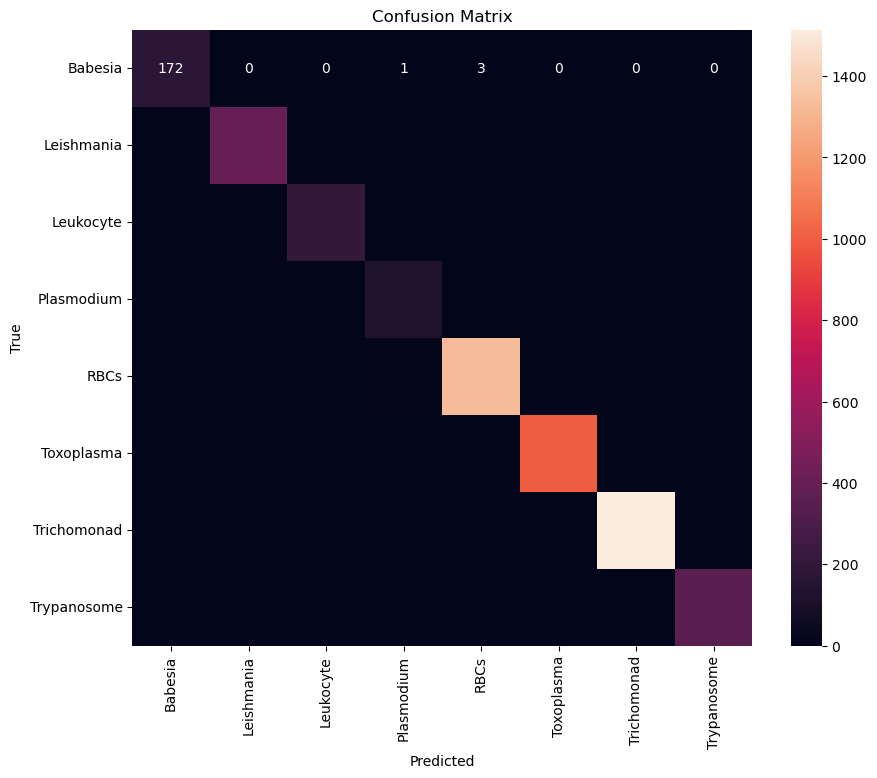

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

preds = model.predict(test_loader)
y_pred = np.argmax(preds, axis=1)
y_true = test_loader.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_loader.class_indices.keys(),
            yticklabels=test_loader.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [88]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=test_loader.class_indices.keys()
))

              precision    recall  f1-score   support

     Babesia       0.99      0.98      0.99       176
  Leishmania       0.99      0.99      0.99       405
   Leukocyte       1.00      1.00      1.00       207
  Plasmodium       0.87      0.96      0.91       126
        RBCs       0.99      0.98      0.99      1350
  Toxoplasma       1.00      1.00      1.00      1003
 Trichomonad       1.00      1.00      1.00      1520
 Trypanosome       0.98      1.00      0.99       358

    accuracy                           0.99      5145
   macro avg       0.98      0.99      0.98      5145
weighted avg       0.99      0.99      0.99      5145



In [89]:
model.save("baseline_efficientnet_b0_99acc.keras")

with open("baseline_metrics b0.txt", "w") as f:
    f.write("Test Accuracy: 0.9903\n")
    f.write("Macro F1: 0.98\n")
    f.write("Plasmodium F1: 0.91\n")

<h1> EfficientNet B0 + Vision Transformer

In [108]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Dense, Dropout, Reshape,
    LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model

# Backbone
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = True

for layer in base_model.layers[:-15]:
    layer.trainable = False

feature_map = base_model.output  # (None, 7, 7, 1280)

# Convert 7x7 feature map → 49 tokens
x = Reshape((49, 1280))(feature_map)

# ---- Transformer Block ----
attention_output = tf.keras.layers.MultiHeadAttention(
    num_heads=4,
    key_dim=128
)(x, x)

x = tf.keras.layers.Add()([x, attention_output])
x = LayerNormalization()(x)

ffn = Dense(512, activation="relu")(x)
ffn = Dense(1280)(ffn)

x = tf.keras.layers.Add()([x, ffn])
x = LayerNormalization()(x)

# Pool tokens
x = GlobalAveragePooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(8, activation='softmax')(x)

hybrid_model = Model(inputs=base_model.input, outputs=output)

In [109]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-5,
    clipnorm=1.0
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)


In [110]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

In [111]:

hybrid_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

In [ ]:
history = hybrid_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    callbacks=[lr_scheduler]
)

Epoch 1/10
751/751 [==============================] - 980s 1s/step - loss: 0.6465 - accuracy: 0.9491 - val_loss: 0.5329 - val_accuracy: 0.9901 - lr: 5.0000e-05
Epoch 2/10
751/751 [==============================] - 961s 1s/step - loss: 0.5478 - accuracy: 0.9872 - val_loss: 0.5121 - val_accuracy: 0.9918 - lr: 5.0000e-05
Epoch 3/10
751/751 [==============================] - 958s 1s/step - loss: 0.5284 - accuracy: 0.9921 - val_loss: 0.5006 - val_accuracy: 0.9940 - lr: 5.0000e-05
Epoch 4/10
751/751 [==============================] - 969s 1s/step - loss: 0.5168 - accuracy: 0.9945 - val_loss: 0.4979 - val_accuracy: 0.9949 - lr: 5.0000e-05
Epoch 5/10
751/751 [==============================] - 956s 1s/step - loss: 0.5105 - accuracy: 0.9957 - val_loss: 0.4919 - val_accuracy: 0.9948 - lr: 5.0000e-05
Epoch 6/10
751/751 [==============================] - 965s 1s/step - loss: 0.5048 - accuracy: 0.9963 - val_loss: 0.4856 - val_accuracy: 0.9953 - lr: 5.0000e-05
Epoch 7/10
751/751 [====================

In [113]:
history = hybrid_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=12,  # extend
    initial_epoch=10,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 11/12
751/751 [==============================] - 1345s 2s/step - loss: 0.4893 - accuracy: 0.9979 - val_loss: 0.4801 - val_accuracy: 0.9967 - lr: 2.5000e-05
Epoch 12/12
751/751 [==============================] - 1333s 2s/step - loss: 0.4870 - accuracy: 0.9987 - val_loss: 0.4789 - val_accuracy: 0.9965 - lr: 2.5000e-05


<h3> Metrics

In [114]:
from sklearn.metrics import classification_report
import numpy as np

preds = hybrid_model.predict(test_loader)
y_pred = np.argmax(preds, axis=1)
y_true = test_loader.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=test_loader.class_indices.keys()
))

161/161 [==============================] - 230s 1s/step
              precision    recall  f1-score   support

     Babesia       1.00      0.98      0.99       176
  Leishmania       1.00      0.99      0.99       405
   Leukocyte       1.00      1.00      1.00       207
  Plasmodium       0.95      0.95      0.95       126
        RBCs       0.99      1.00      0.99      1350
  Toxoplasma       1.00      1.00      1.00      1003
 Trichomonad       1.00      1.00      1.00      1520
 Trypanosome       1.00      1.00      1.00       358

    accuracy                           1.00      5145
   macro avg       0.99      0.99      0.99      5145
weighted avg       1.00      1.00      1.00      5145



<h2> Test on Unseen data

In [115]:
test_loss, test_acc = hybrid_model.evaluate(test_loader)
print("Test Accuracy:", test_acc)

161/161 [==============================] - 218s 1s/step - loss: 0.4808 - accuracy: 0.9959
Test Accuracy: 0.9959183931350708


<h3> baseline ViT + Enet model

In [99]:
hybrid_model.save("hybrid_efficientnet_vit_baseline.keras")

hybrid_model.save_weights("hybrid_weights_baseline.h5")

with open("hybrid_metrics_baseline.txt", "w") as f:
    f.write("Test Accuracy: 0.99\n")
    f.write("Macro F1: 0.98\n")
    f.write("Plasmodium F1: 0.91\n")

    import json

with open("hybrid_history.json", "w") as f:
    json.dump(history.history, f)

<h3> Finetuned ViT + Enet model

In [ ]:
hybrid_model.save("hybrid_efficientnet_vit_finetuned_99.keras")

hybrid_model.save_weights("hybrid_weights_finetuned_99.h5")

with open("hybrid_metrics_finedtuned_99.txt", "w") as f:
    f.write("Test Accuracy: 0.99\n")
    f.write("Macro F1: 0.98\n")
    f.write("Plasmodium F1: 0.95\n")

import json

# Convert numpy float32 to normal float
history_dict = {
    key: [float(x) for x in values]
    for key, values in history.history.items()
}

with open("hybrid_finetuned_99_history.json", "w") as f:
    json.dump(history_dict, f)

<h1> GRAD-CAM XAI CODE FOR BASELINE EFFICIENTNETB0 MODEL

<h4> 🔴 Red = Strong contribution

🟠 Orange/Yellow = Moderate contribution

🟢 Green = Low contribution

🔵 Blue = Very little contribution

🟣 Purple = Near-zero contribution <h4>


Grad-CAM for class: Babesia
1/1 [==============================] - 1s 1s/step


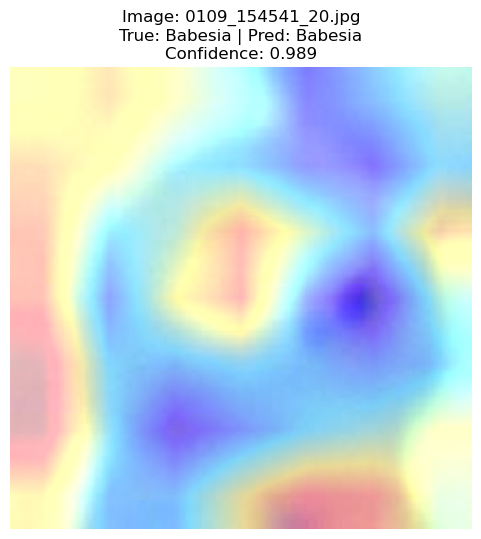


Grad-CAM for class: Leishmania
1/1 [==============================] - 0s 60ms/step


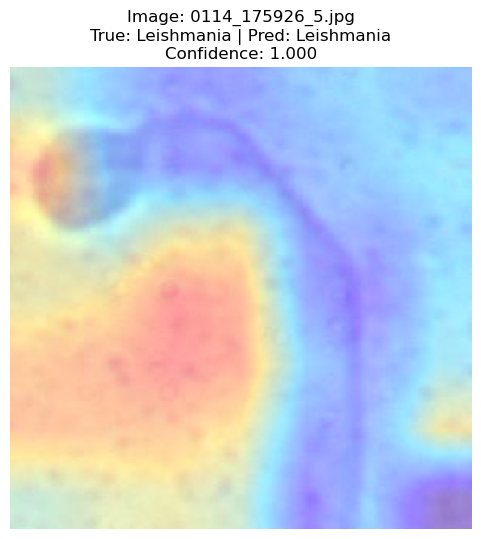


Grad-CAM for class: Leukocyte
1/1 [==============================] - 0s 60ms/step


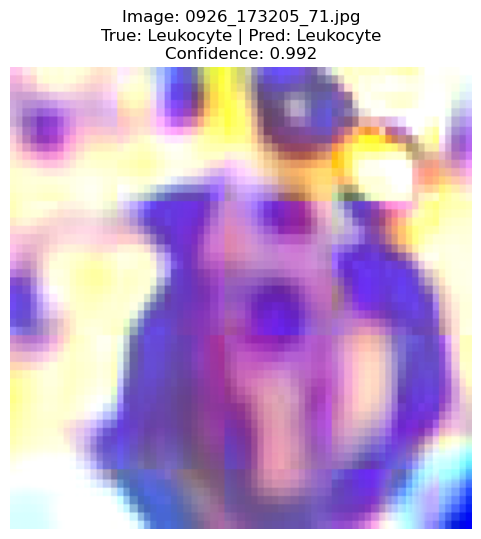


Grad-CAM for class: Plasmodium
1/1 [==============================] - 0s 59ms/step


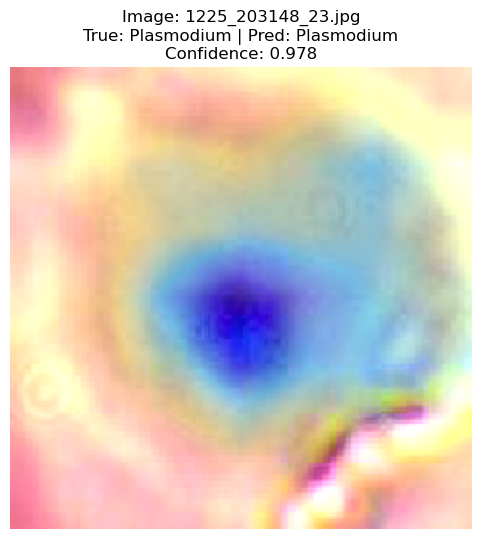


Grad-CAM for class: RBCs
1/1 [==============================] - 0s 80ms/step


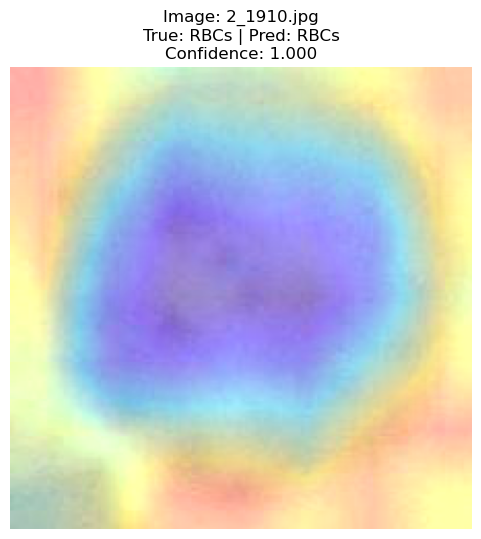


Grad-CAM for class: Toxoplasma
1/1 [==============================] - 0s 57ms/step


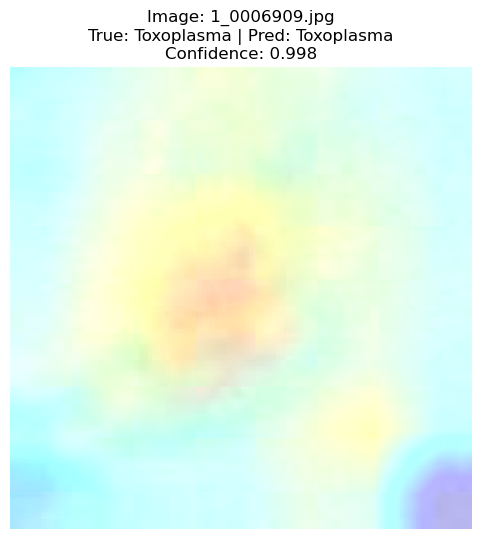


Grad-CAM for class: Trichomonad
1/1 [==============================] - 0s 58ms/step


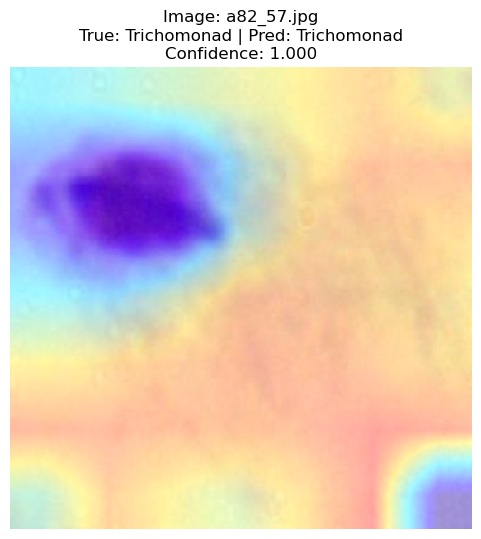


Grad-CAM for class: Trypanosome
1/1 [==============================] - 0s 66ms/step


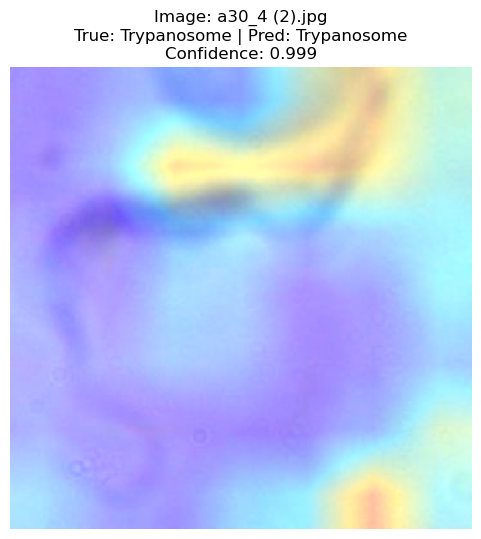

In [124]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os

# -----------------------------
# 1️⃣ Load Model
# -----------------------------
model = tf.keras.models.load_model("baseline_efficientnet_b0_99acc.keras")

# -----------------------------
# 2️⃣ Load Class Mapping
# -----------------------------
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}

# -----------------------------
# 3️⃣ Grad-CAM Function
# -----------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -----------------------------
# 4️⃣ Last Conv Layer Name
# -----------------------------
last_conv_layer_name = "top_conv"

# -----------------------------
# 5️⃣ Display Function
# -----------------------------
def display_gradcam(img_path, true_label):
    img_name = os.path.basename(img_path)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_array_exp = tf.keras.applications.efficientnet.preprocess_input(img_array_exp)

    preds = model.predict(img_array_exp)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]

    heatmap = make_gradcam_heatmap(
        img_array_exp,
        model,
        last_conv_layer_name,
        pred_index=pred_class
    )

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.4 + img_array
    superimposed_img = np.clip(superimposed_img / 255.0, 0, 1)

    plt.figure(figsize=(6,6))
    plt.title(
        f"Image: {img_name}\n"
        f"True: {true_label} | Pred: {index_to_class[pred_class]}\n"
        f"Confidence: {confidence:.3f}"
    )
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

# -----------------------------
# 6️⃣ Run for One Image Per Class
# -----------------------------
for class_name in class_indices.keys():
    sample_path = test_df[test_df["label"] == class_name]["filepath"].sample(1).values[0]
    print(f"\nGrad-CAM for class: {class_name}")
    display_gradcam(sample_path, class_name)

<h2> GRAD CAM XAI FOR ENET + VIT MODEL

In [ ]:
import tensorflow as tf
import numpy as np
import json
import os

# --------------------------------------------------
# 1️ Load FINETUNED Hybrid Model (IMPORTANT)
# --------------------------------------------------
model = tf.keras.models.load_model(
    "hybrid_efficientnet_vit_finetuned_99.keras",
    compile=False
)

print("Model loaded successfully.")
print("Output shape:", model.output_shape)

# --------------------------------------------------
# 2️ Load Correct Class Mapping
# --------------------------------------------------
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}

print("\nClass Mapping:")
print(class_indices)

# --------------------------------------------------
# 3️ Pick Random Test Image
# --------------------------------------------------
sample_row = test_df.sample(1).iloc[0]
img_path = sample_row["filepath"]
true_label = sample_row["label"]

print("\nTesting image:", os.path.basename(img_path))
print("True label:", true_label)

# --------------------------------------------------
# 4 Load & Preprocess Image (CRITICAL)
# --------------------------------------------------
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# EfficientNet preprocessing (DO NOT REMOVE)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# --------------------------------------------------
# 5️ Predict
# --------------------------------------------------
preds = model.predict(img_array)

print("\nRaw softmax output:")
print(preds)

print("\nSum of probabilities:", np.sum(preds))

pred_class = np.argmax(preds[0])
confidence = float(preds[0][pred_class])

print("\nPredicted class:", index_to_class[pred_class])
print("Confidence:", round(confidence, 4))

Model loaded successfully.
Output shape: (None, 8)

Class Mapping:
{'Babesia': 0, 'Leishmania': 1, 'Leukocyte': 2, 'Plasmodium': 3, 'RBCs': 4, 'Toxoplasma': 5, 'Trichomonad': 6, 'Trypanosome': 7}

Testing image: a101_2.jpg
True label: Trichomonad
1/1 [==============================] - 2s 2s/step

Raw softmax output:
[[0.01142775 0.01292541 0.01355159 0.00962476 0.01160888 0.01141682
  0.9170344  0.01241034]]

Sum of probabilities: 0.99999994

Predicted class: Trichomonad
Confidence: 0.917


Hybrid model loaded.
Output shape: (None, 8)

Grad-CAM for class: Babesia


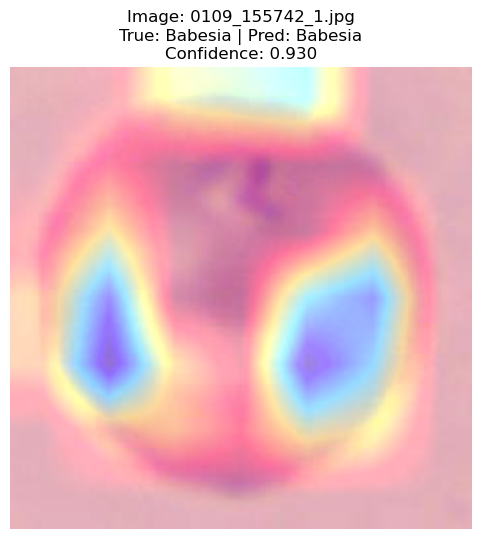


Grad-CAM for class: Leishmania


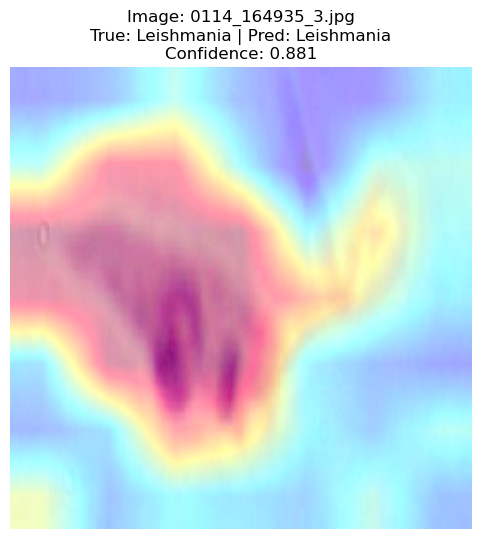


Grad-CAM for class: Leukocyte


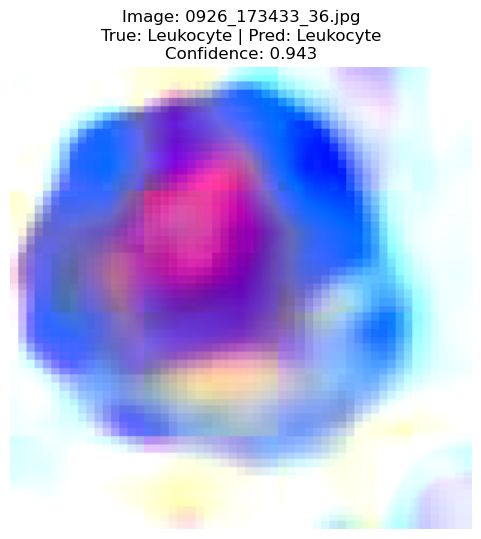


Grad-CAM for class: Plasmodium


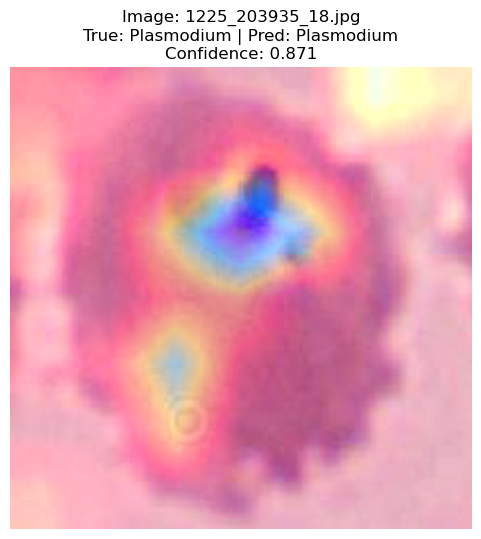


Grad-CAM for class: RBCs


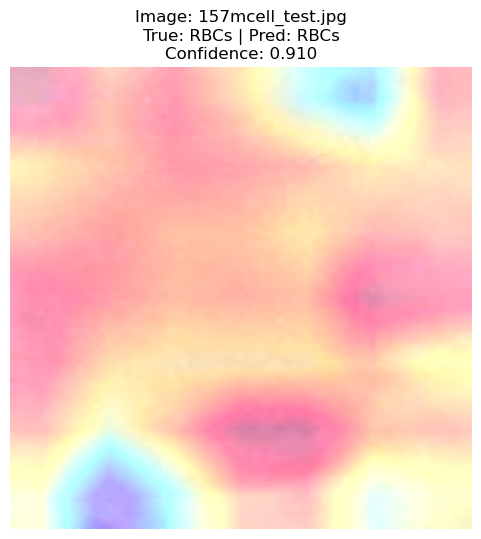


Grad-CAM for class: Toxoplasma


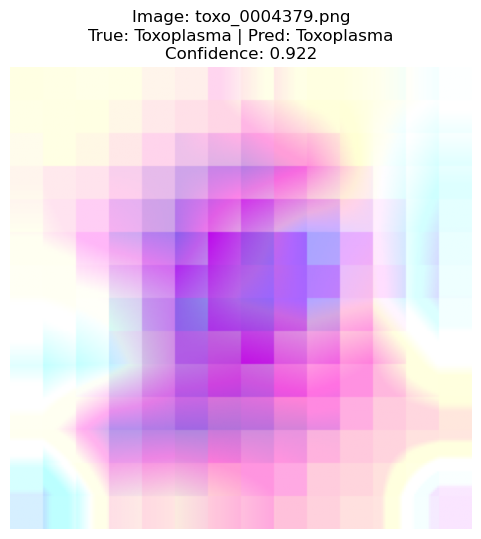


Grad-CAM for class: Trichomonad


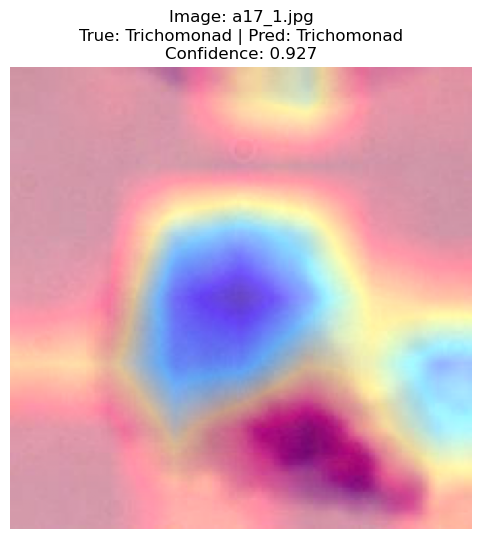


Grad-CAM for class: Trypanosome


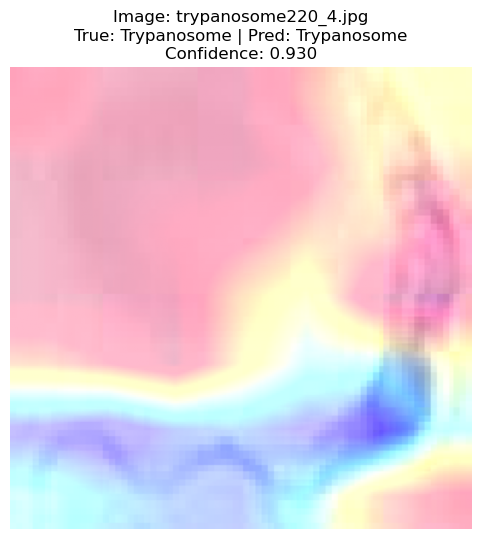

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os

# --------------------------------------------------
# 1️ Load FINETUNED Hybrid Model
# --------------------------------------------------
model = tf.keras.models.load_model(
    "hybrid_efficientnet_vit_finetuned_99.keras",
    compile=False
)

print("Hybrid model loaded.")
print("Output shape:", model.output_shape)

# --------------------------------------------------
# 2️ Load Class Mapping
# --------------------------------------------------
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

index_to_class = {v: k for k, v in class_indices.items()}

# --------------------------------------------------
# 3️ Grad-CAM Function
# --------------------------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --------------------------------------------------
# 4️ EfficientNet Last Conv Layer Name
# --------------------------------------------------
last_conv_layer_name = "top_conv"

# --------------------------------------------------
# 5️ Display Grad-CAM
# --------------------------------------------------
def display_gradcam(img_path, true_label):

    img_name = os.path.basename(img_path)

    # Load image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)

    # EfficientNet preprocessing (CRITICAL)
    img_array_exp = tf.keras.applications.efficientnet.preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_array_exp, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = float(preds[0][pred_class])

    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        img_array_exp,
        model,
        last_conv_layer_name,
        pred_index=pred_class
    )

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay
    superimposed_img = heatmap * 0.4 + img_array
    superimposed_img = np.clip(superimposed_img / 255.0, 0, 1)

    plt.figure(figsize=(6,6))
    plt.title(
        f"Image: {img_name}\n"
        f"True: {true_label} | Pred: {index_to_class[pred_class]}\n"
        f"Confidence: {confidence:.3f}"
    )
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

# --------------------------------------------------
# 6️ Run Grad-CAM for One Random Image Per Class
# --------------------------------------------------
for class_name in class_indices.keys():
    sample_path = test_df[test_df["label"] == class_name]["filepath"].sample(1).values[0]
    print(f"\nGrad-CAM for class: {class_name}")
    display_gradcam(sample_path, class_name)